# Notebook to test methods for extracting kinematics from highspeed video

## Imports

In [754]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.filters import threshold_otsu, gaussian, threshold_multiotsu, sobel
from skimage.util import invert, img_as_float, img_as_ubyte, img_as_uint
import skimage.morphology  as morphology
from skimage.segmentation import clear_border, flood, flood_fill, watershed
from skimage.exposure import equalize_hist, equalize_adapthist, rescale_intensity
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.feature import peak_local_max

from mosquito.read_photron import my_read_cih, my_read_mraw


## Set params

In [755]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


## Helper functions

In [756]:
def my_get_fg(image):
    """
    Quick and dirty function to pull binary mosquito mask out from image
    
    """
    # filter image
    image = invert(image)
    image = gaussian(image, sigma=1)
    image = equalize_adapthist(image, kernel_size=40)

    # threshold
    thresholds = threshold_multiotsu(image,2)
    threshold = thresholds[-1]
    bw = image > threshold

    # morphology
    erode_rad = 20  # 12
    dilate_rad = erode_rad + 5
    
    bw2 = morphology.isotropic_erosion(bw, erode_rad)
    bw3 = clear_border(bw2)
    bw4 = bw2 & ~bw3
    bw4 = morphology.isotropic_dilation(bw4, dilate_rad)
    bw5 = np.asarray(~bw4)*bw

    # take largest CC
    bw_label = label(bw5.astype(int), connectivity=2)
    props = regionprops(bw_label)

    areas = [p['area'] for p in props]
    max_ind = np.argmax(np.asarray(areas))
    
    bw_trim = np.zeros_like(bw5)
    coords = props[max_ind]['coords']
    bw_trim[coords[:,0], coords[:,1]] = True

    return bw_trim
    

In [913]:
# def draw_line(img, window_name='draw line (press ENTER to exit)'):
#     """
#     Draw a line on an image (img) and return coordinates
#     """
#     clone = img.copy()

#     if clone.dtype == 'uint16':
#         pix_val = 65535
#     else:
#         pix_val = 255
        
#     class LinePoints:
#         line_points = []

#     def select_line_pts(event, x, y, flags, param):
#         if event == cv2.EVENT_LBUTTONDOWN:
#             LinePoints.line_points = []
#             LinePoints.line_points.append((x, y))
#             cv2.circle(img, (x, y), 2, (pix_val, 0, 0, pix_val), -1)

#         elif event == cv2.EVENT_LBUTTONUP:
#             LinePoints.line_points.append((x, y))
#             cv2.line(img, LinePoints.line_points[-2], (x, y), (pix_val, 0, 0, pix_val))

#     cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
#     cv2.setMouseCallback(window_name, select_line_pts)
#     while (1):
#         cv2.imshow(window_name, img)
#         k = cv2.waitKey(1) & 0xFF
#         if k == 27:
#             img = clone.copy()
#         elif k == 13:
#             break

#     img = clone.copy()
#     cv2.destroyAllWindows()
#     # out_pts = np.asarray(LinePoints.line_points)
#     return LinePoints.line_points


In [889]:
class Handle(object):
    """
    Handle class from Kinefly
    """
    def __init__(self, pt=np.array([0,0]), color=(255.0, 255.0, 255.0, 0.0), name=None):
        self.pt = pt
        self.name = name
        self.scale = 1.0

        self.color = color
        self.radiusDraw = 3
        self.radiusHit = 6


    def hit_test(self, ptMouse):
        d = np.linalg.norm(self.pt - ptMouse)
        if (d < self.radiusHit):
            return True
        else:
            return False
        
    def draw(self, image):
        cv_filled = -1
        cv2.circle(image, tuple(self.pt.astype(int)),  self.radiusDraw, self.color, cv_filled)


In [943]:
class MyLine(object):
    """
    Line class adapted from Kinefly
    """
    def __init__(self, name=None, color=(255.0, 255.0, 255.0, 0.0), start_pt=np.array([0,0]), end_pt=np.array([20,20]), image=None):
        self.color = color
        self.name = name

        self.start_pt = start_pt
        self.end_pt = end_pt
        self.handles = {'start_pt': Handle(start_pt, (0.0, 255.0, 0.0, 0.0), name='start_pt'),
                        'end_pt': Handle(end_pt, (0.0, 0.0, 255.0, 0.0), name='end_pt')}
        self.image = image
        self.image_shape = np.array([1,1])

        self.mousing = False
        self.current_tag = None
        
    # update the values of handle points start_pt and end_pt
    def update_handle_points (self):
        self.handles['start_pt'].pt = self.start_pt
        self.handles['end_pt'].pt = self.end_pt

    
    # Draw all handle points
    def draw_handles(self, image):
        for tagHandle,handle in self.handles.items():
            handle.draw(image)
        

    # Draw the line connecting the handles + handles themselves
    def draw(self):
        # draw handle points
        image = self.image
        self.draw_handles(image)
        
        # draw line
        cv2.line(image, self.start_pt, self.end_pt, self.color, 1)
    

    # Get the UI object, if any, that the mouse is on.    
    def hit_object(self, pt_mouse):
        tag = None
        
        # Check for handle hits.
        for tagHandle, handle in self.handles.items():
            if (handle.hit_test(pt_mouse)):
                tag = tagHandle
                break
              
        return (self.name, tag)

    
     # Callback function for mouse clicks in simple line gui
    def on_mouse(self, event, x, y, flags, param):
        # get mouse click point
        img_shape = self.image.shape[:2][::-1]
        pt_mouse = np.array([x, y]).clip((0,0), img_shape)
        tag = None
        
        # Keep track of which UI element is selected.
        if (event==cv2.EVENT_LBUTTONDOWN):
            # Get the name and ui nearest the current point.
            name, tag = self.hit_object(pt_mouse)
            self.current_tag = tag
            self.mousing = True
            
        elif (event==cv2.EVENT_LBUTTONUP):
            self.mousing = False
            self.current_tag = None
            
        # update coordinates based on mouse movement
        tag = self.current_tag
        if tag is not None:
            setattr(self, tag, pt_mouse)
            self.update_handle_points()   


In [941]:
def my_get_body_axis(img, start_pt_init=None, end_pt_init=None):
    """
    Function to add a draggable body axis to image so that the user can manually mark body axis

    To use, put the green dot at the estimated body center of mass and the red dot at the fly's
    head, such that the line in between defines the long body axis direction
    
    """
    # make copy of input image
    clone = img.copy()

    # generate opencv window
    window_name = 'get body axis (press ENTER to continue)'
    cv2.namedWindow(window_name,  cv2.WINDOW_NORMAL)

    # generate a line object
    if start_pt_init is None:
        h, w = img.shape[:2]
        start_pt_init = np.array([int(w/2), int(h/2)])
    if end_pt_init is None:
        h, w = img.shape[:2]
        end_pt_init = np.array([0, int(h/2)])

        
    axis_line = MyLine(start_pt=start_pt_init, end_pt=end_pt_init)
    axis_line.image = img

    # set callback
    cv2.setMouseCallback(window_name, axis_line.on_mouse)

    # loop to allow image update
    while (1):
        axis_line.image = clone.copy()
        axis_line.draw()
        cv2.imshow(window_name, axis_line.image)
        
        k = cv2.waitKey(1) & 0xFF
        if k == 13:
            break
    
    img = clone.copy()
    cv2.destroyAllWindows()

    # once we exit, grab start and end points
    body_cm = axis_line.start_pt
    head_pt = axis_line.end_pt

    return (body_cm, head_pt)
    

## Load data

In [757]:
# path to data files
# paths to data
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '21_20240515'  # '16_20240506'  #      
axo_num = 1  # 1 # 

data_path = os.path.join(data_root, data_folder, '*_{:04d}'.format(axo_num))
vid_path_full = glob.glob(os.path.join(data_path, '*/*.mraw'))[0]
vid_path_full


'/media/sam/SamData/Mosquitoes/21_20240515/2024_05_15_0001/aedes_C001H001S0001_20240515_171528/aedes_C001H001S0001_20240515_171528.mraw'

In [758]:
# read video -- only some of the frames
frames = (0, 1000)
imgs, metadata = my_read_mraw(vid_path_full, frames=frames)


/home/sam/Documents/code/mosquito/src/mosquito/read_photron.py:179: UserWarning: Clipped footage! (Total frame: 12476, Orig. total frame: 13973)
  warnings.warn('Clipped footage! (Total frame: {}, Orig. total frame: {})'.format(cih['Total Frame'],


Reading /media/sam/SamData/Mosquitoes/21_20240515/2024_05_15_0001/aedes_C001H001S0001_20240515_171528/aedes_C001H001S0001_20240515_171528.mraw
PFV 12-bit MRAW
File contains 12476 frames (640 x 640)
Reading frames 0 to 1000
Read 585.0 MiB in 6.1 sec
	Data in memory:	 (1000, 640, 640)
	Intensity range:	 0 to 4095 	 uint16
	Array size:	781.2 MB


In [759]:
imgs.dtype

dtype('uint16')

## Binarize images
I think our lighting conditions are good enough where this won't be a problem

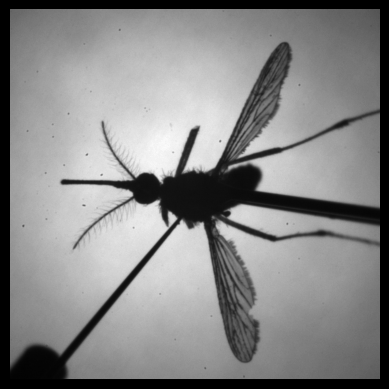

In [760]:
# look at a frame
fig, ax = plt.subplots()

ax.imshow(imgs[0,:,:], cmap='grey')
ax.set_axis_off()


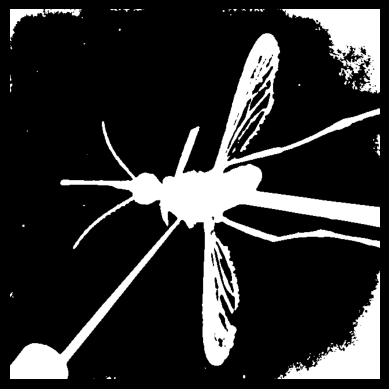

In [761]:
# try simple binarization
ex_ind = 10
image = invert(imgs[ex_ind])
image = gaussian(image)
image = equalize_adapthist(image, kernel_size=40)

# threshold = threshold_otsu(image)
thresholds = threshold_multiotsu(image,2)
threshold = thresholds[-1]
bw = image > threshold

# visualize
fig, ax = plt.subplots()
ax.imshow(bw, cmap='grey')
ax.set_axis_off()


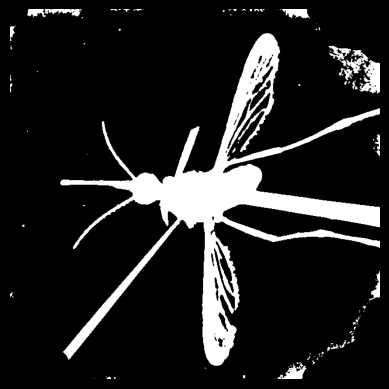

In [762]:
# probably want to erode this to remove stuff around edges
erode_rad = 20 # 12
dilate_rad = erode_rad + 5

bw2 = morphology.isotropic_erosion(bw, erode_rad)
bw3 = clear_border(bw2)
bw4 = bw2 & ~bw3
bw4 = morphology.isotropic_dilation(bw4, dilate_rad)
bw5 = np.asarray(~bw4)*bw

# visualize
fig, ax = plt.subplots()
ax.imshow(bw5, cmap='grey')
ax.set_axis_off()

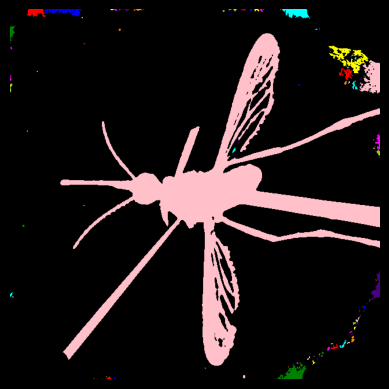

In [763]:
# get region props of bw image
bw_label = label(bw5.astype(int), connectivity=2)

fig, ax = plt.subplots()
ax.imshow(label2rgb(bw_label))
ax.set_axis_off()

props = regionprops(bw_label)


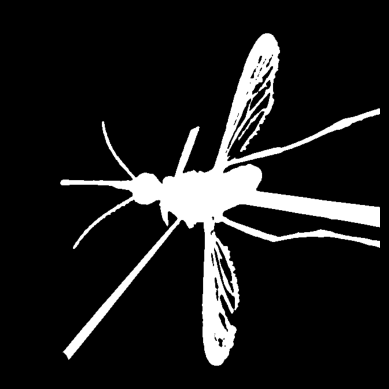

In [764]:
# take biggest component
areas = [p['area'] for p in props]
max_ind = np.argmax(np.asarray(areas))

bw_trim = np.zeros_like(bw5)
coords = props[max_ind]['coords']
bw_trim[coords[:,0], coords[:,1]] = True

fig, ax = plt.subplots()
ax.imshow(bw_trim, cmap='grey')
# ax.plot(320, 320, 'ro')
ax.set_axis_off()

In [765]:
# try getting foreground for all images
imgs_fg = np.zeros(imgs.shape, dtype=bool)

for ith in range(imgs.shape[0]):
    image = imgs[ith]
    
    fgmask = my_get_fg(image)
    imgs_fg[ith,:,:] = fgmask
    
    # fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel) 
    cv2.imshow('fgmask', 255*fgmask.astype('uint8')) 
    cv2.imshow('frame', image.astype('uint8') ) 
  
    k = cv2.waitKey(30) & 0xff
    if k == 27: 
        break
        

In [766]:
cv2.destroyAllWindows()

## Detect wings

I think I can extract the wings by looking at pixels that change from frame to frame (ala fly code from Cohen Lab). Probably a simple threshold will get body, but have to separate tether from that

In [767]:
# first just get non-moving pixels (this should be body + electrodes + legs)
roll_window = 20
imgs_fixed = np.zeros_like(imgs_fg)
imgs_moving = np.zeros_like(imgs_fg)

for ith in range(imgs_fg.shape[0]):
    # fixed pixels are just present in all images
    idx1 = max([0, ith - roll_window])
    idx2 = min([imgs.shape[0]-1, ith + roll_window])
    fixed =  np.all(imgs_fg[idx1:idx2], axis=0)

    # to get moving pixels, do some extra processing
    moving =  np.logical_xor(imgs_fg[ith], fixed)
    moving = morphology.isotropic_opening(moving, 1)
    moving = morphology.isotropic_closing(moving, 10)
    moving = morphology.remove_small_holes(moving, area_threshold=2000)
    moving = morphology.remove_small_objects(moving, min_size=300)
    # store
    imgs_fixed[ith] = fixed
    imgs_moving[ith] = moving

    # visualize
    cv2.imshow('wings', 255*moving.astype('uint8')) 
    cv2.imshow('fixed', 255*fixed.astype('uint8') ) 
  
    k = cv2.waitKey(30) & 0xff
    if k == 27: 
        break

cv2.destroyAllWindows()

In [768]:
# # try to remove uneven lighting in background
# image = img_as_float(image)
# h = 0.4
# seed = image - h
# dilated = morphology.reconstruction(seed, image, method='dilation')
# hdome = image - dilated

# # visualize
# fig, ax = plt.subplots()
# ax.imshow(hdome, cmap='grey')
# ax.set_axis_off()



In [769]:
# # open image to remove remaining border noise
# bw6 = morphology.binary_opening(bw5,

## Try extracting angles

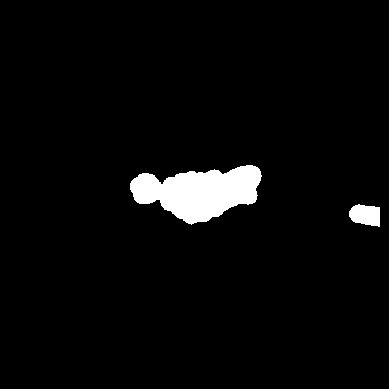

In [770]:
# would be nice to define body axis automatically. can I do this by eroding body image?
body_bw = np.sum(imgs_fixed, axis=0)
# body_bw_open = morphology.isotropic_erosion(body_bw, 5)
body_bw_open = morphology.isotropic_opening(body_bw, 16)


fig, ax = plt.subplots()
ax.imshow(body_bw_open, interpolation='none', cmap='grey') # 
ax.set_axis_off()

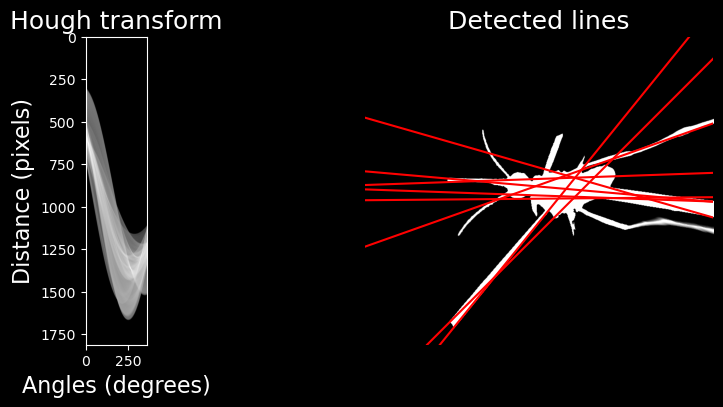

In [771]:
# try hough line detection? didn't work well last time...
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

image = body_bw
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [
    np.rad2deg(theta[0] - angle_step),
    np.rad2deg(theta[-1] + angle_step),
    d[-1] + d_step,
    d[0] - d_step,
]
ax1.imshow(np.log(1 + h), cmap='grey')
ax1.set_title('Hough transform')
ax1.set_xlabel('Angles (degrees)')
ax1.set_ylabel('Distance (pixels)')
ax1.axis('image')

ax2.imshow(image, cmap='grey')
ax2.set_ylim((image.shape[0], 0))
ax2.set_axis_off()
ax2.set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax2.axline((x0, y0), slope=np.tan(angle + np.pi / 2), color='r')


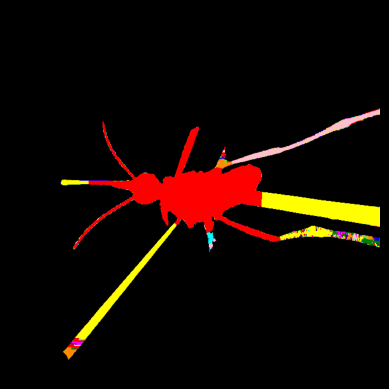

In [772]:
# watershed
from scipy import ndimage as ndi

image = body_bw
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((150, 150)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, ax = plt.subplots()

ax.imshow(label2rgb(labels))
ax.set_axis_off()


In [944]:
a = np.array([1,2]) 
b = np.array([4,5])


array([2.5, 3.5])

## Resorting to manual approach for now

In [942]:
# try to estimate body axis via line
# first get example image and set to 8bit rgb
img = imgs[0]
img_8bit = (img/255).astype('uint8')
img_8bit =  cv2.cvtColor(rescale_intensity(img_8bit),cv2.COLOR_GRAY2RGB)

thorax_pt, head_pt = my_get_body_axis(img_8bit)
print(thorax_pt)
print(head_pt)


[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[  0 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]
[320 320]


In [908]:
np.asarray(img.shape[:2])

array([640, 640])

In [931]:
tag   = [None, None, 'aux', None,None,None]
# j = next((i for i in range(len(tag)) if tag[i]!=None), None)
j =[i for i in range(len(tag)) if tag[i]!=None]

print(j)

[2]


In [939]:
class test_child(object):
    def __init__(self, val=None):
        self.val = val
    def my_fun(self):
        print(self.val)


class test(object):
    def __init__(self):
        self.a = test_child(val=0)
        self.b = test_child(val=1)

my_test = test()
getattr(my_test, 'a').my_fun()
# my_test.b.my_fun()

0


## Trying mixture of gaussians bg subtraction

In [573]:
# trying opencv approach
fgbg = cv2.createBackgroundSubtractorMOG2(history=100, detectShadows=False, varThreshold=3)
# fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()

imgs_fg_mog = np.zeros(imgs.shape, dtype=bool)

for ith in range(imgs.shape[0]):
    frame = imgs[ith]
    frame = gaussian(frame, sigma=1)
    frame = img_as_ubyte(rescale_intensity(frame))
    # frame = img_as_ubyte(equalize_hist(frame))
    # frame = gaussian(frame, sigma=3)
    # frame = invert(frame)
    
    fgmask = fgbg.apply(frame) 
    imgs_fg_mog[ith,:,:] = fgmask
    
    # fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel) 
    cv2.imshow('fgmask', fgmask) 
    cv2.imshow('frame',frame ) 
  
    k = cv2.waitKey(30) & 0xff
    if k == 27: 
        break
        

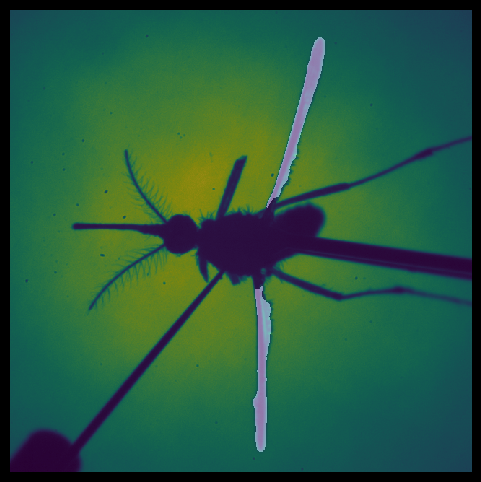

In [681]:
ex_ind = 24
fig, ax = plt.subplots(figsize=(6,6))

# fly_sobel = sobel(imgs[ex_ind])
# fly_flood = flood(fly_sobel, (1, 1), tolerance=0.001)
# ax.imshow(imgs[ex_ind], interpolation='none')
# ax.imshow(fly_flood, interpolation='none', cmap=plt.cm.gray)

img_invert = invert(imgs[ex_ind])
mask = imgs_moving[ex_ind]
out = img_invert * ((2**16-1)*mask.astype('uint16'))

ax.imshow(imgs[ex_ind], interpolation='none')
# ax.imshow(mask, interpolation='none', cmap='grey', alpha=0.4)
ax.set_axis_off()

# ax.imshow(imgs_moving[ex_ind], interpolation='none', alpha=0.4, cmap='grey')

fg_mog = imgs_fg_mog[ex_ind]
fg_mog = morphology.isotropic_closing(fg_mog, 4)
# ax.imshow(fg_mog , interpolation='none', alpha=0.4, cmap='grey')


In [656]:
imgs[ex_ind].dtype

dtype('uint16')

In [409]:
cv2.destroyAllWindows()"

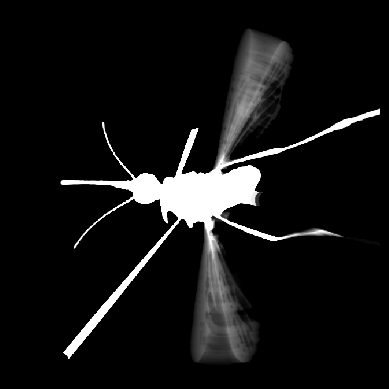

In [585]:
# try to look at all moving pixels?
img_fg_sum = np.sum(imgs_fg.astype('float64'), axis=0)
fig, ax = plt.subplots()
ax.imshow(img_fg_sum, cmap='grey', interpolation='none')
ax.set_axis_off()

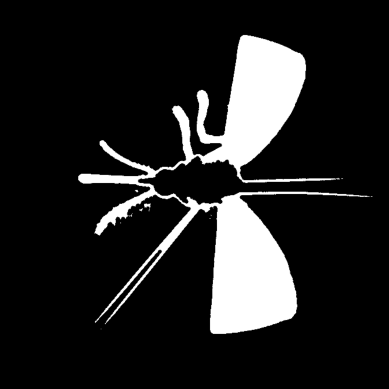

In [425]:
# try to binarize this to get mask of where wings could possibly be
threshold = threshold_otsu(img_fg_sum )
bw = img_fg_sum  > threshold
# thresholds = threshold_multiotsu(img_fg_sum, 4)
# bw = img_fg_sum  > thresholds[0]

bw = morphology.isotropic_opening(bw, 3)
bw = morphology.isotropic_closing(bw, 7)
bw = morphology.remove_small_holes(bw, area_threshold=1e5)
# bw = morphology.isotropic_dilation(bw, 10)

# visualize
fig, ax = plt.subplots()
ax.imshow(bw, cmap='grey')
ax.set_axis_off()


In [405]:
# do a second round of bg subtractions to get a better fg estimage
imgs_fg = np.zeros(imgs.shape, dtype=bool)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)) 

for ith in range(imgs.shape[0]):
    frame = imgs[ith]
    frame = gaussian(frame, sigma=1)
    frame = img_as_ubyte(rescale_intensity(frame))
    # frame = img_as_ubyte(equalize_hist(frame))
    # frame = invert(frame)
    
    fgmask = fgbg.apply(frame) 
    fgmask = fgmask * bw.astype('bool')
    fgmask = fgmask > 0.5
    # fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel) 
    
    fgmask =  morphology.remove_small_objects(fgmask, min_size=12)
    # fgmask = morphology.isotropic_closing(fgmask, 1)
    
    imgs_fg[ith,:,:] = fgmask
    
    cv2.imshow('fgmask', 255*fgmask.astype('uint8')) 
    # cv2.imshow('fgmask', fgmask) 
    cv2.imshow('frame',frame ) 
  
    k = cv2.waitKey(30) & 0xff
    if k == 27: 
        break

In [403]:
cv2.destroyAllWindows()

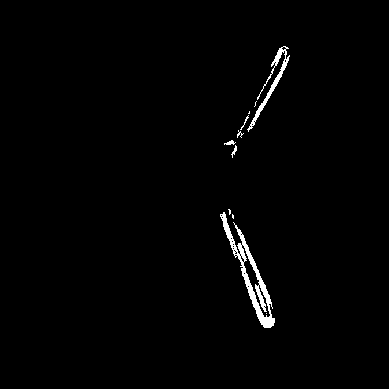

In [404]:
fig, ax = plt.subplots()
ax.imshow(imgs_fg[10], cmap='grey', interpolation='none')
ax.set_axis_off()

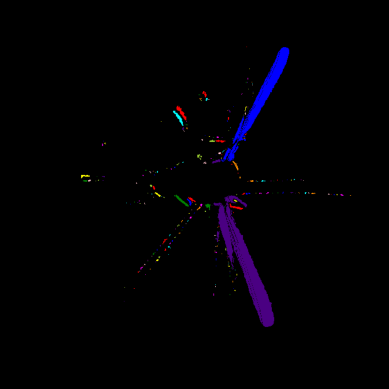

In [446]:
bw_label = label(imgs_fg[10], connectivity=2)

fig, ax = plt.subplots()
ax.imshow(label2rgb(bw_label))
ax.set_axis_off()